In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

C:\Users\mj\AppData\Local\Temp\ipykernel_3552\3168417226.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
finaldata = pd.read_csv("finaldata2.csv")

In [3]:
rainfall = finaldata['Rainfall'].values
waterlevel = finaldata['WaterLevel'].values
fwaterlevel = finaldata['FWaterLevel'].values

In [4]:
scaler_rainfall = MinMaxScaler()
scaler_waterlevel = MinMaxScaler()
scaler_fwaterlevel = MinMaxScaler()
rainfall_scaled = scaler_rainfall.fit_transform(rainfall.reshape(-1, 1))
waterlevel_scaled = scaler_waterlevel.fit_transform(waterlevel.reshape(-1, 1))
fwaterlevel_scaled = scaler_fwaterlevel.fit_transform(fwaterlevel.reshape(-1, 1))

In [5]:
def create_narx_dataset(waterlevel, rainfall, fwaterlevel, n_y, n_u):
    X, y = [], []
    for i in range(len(waterlevel) - max(n_y, n_u)):
        y_input = waterlevel[i:i+n_y].flatten()
        u_input = rainfall[i:i+n_u].flatten()
        X.append(np.concatenate((y_input, u_input)))
        y.append(fwaterlevel[i+n_y])
    return np.array(X), np.array(y)

n_y = 48
n_u = 48
X, y = create_narx_dataset(waterlevel_scaled, rainfall_scaled, fwaterlevel_scaled, n_y, n_u)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
model = Sequential()
model.add(Dense(64, input_dim=n_y + n_u, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation='linear'))

In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
12237/12237 [==============================] - 27s 2ms/step - loss: 4.4847e-05 - mae: 0.0022 - val_loss: 2.1084e-06 - val_mae: 0.0012
Epoch 2/100
12237/12237 [==============================] - 29s 2ms/step - loss: 2.4409e-05 - mae: 0.0016 - val_loss: 7.0916e-06 - val_mae: 0.0021
Epoch 3/100
12237/12237 [==============================] - 31s 3ms/step - loss: 2.3501e-05 - mae: 0.0015 - val_loss: 1.7163e-06 - val_mae: 9.8744e-04
Epoch 4/100
12237/12237 [==============================] - 27s 2ms/step - loss: 2.2991e-05 - mae: 0.0015 - val_loss: 1.8559e-06 - val_mae: 9.7588e-04
Epoch 5/100
12237/12237 [==============================] - 26s 2ms/step - loss: 2.2178e-05 - mae: 0.0014 - val_loss: 3.3823e-06 - val_mae: 0.0013
Epoch 6/100
12237/12237 [==============================] - 29s 2ms/step - loss: 2.1457e-05 - mae: 0.0013 - val_loss: 1.0559e-06 - val_mae: 7.6023e-04
Epoch 7/100
12237/12237 [==============================] - 23s 2ms/step - loss: 2.1117e-05 - mae: 0.0013 - val_l

In [10]:
y_pred = model.predict(X_test)

956/956 [==============================] - 2s 1ms/step


In [11]:
y_test_orig = scaler_fwaterlevel.inverse_transform(y_test.reshape(-1, 1))
y_pred_orig = scaler_fwaterlevel.inverse_transform(y_pred)

In [12]:
def nash_sutcliffe(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (numerator / denominator)

In [13]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
nse = nash_sutcliffe(y_test_orig, y_pred_orig)

print(f"\nModel Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"R² Score: {r2:.2f}")
print(f"Nash-Sutcliffe Efficiency (NSE): {nse:.2f}")
print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")


Model Performance Metrics:
Mean Absolute Error (MAE): 0.10869
R² Score: 0.87
Nash-Sutcliffe Efficiency (NSE): 0.87
Mean Squared Error (MSE): 0.03171
Root Mean Squared Error (RMSE): 0.17807


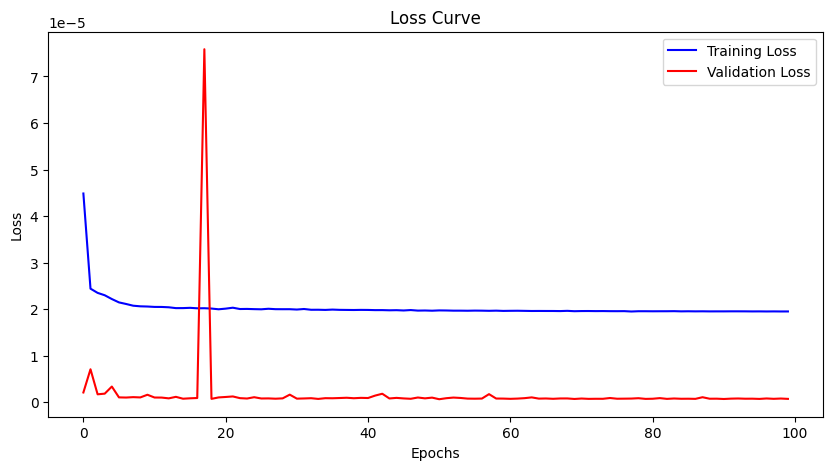

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [15]:
# Print predictions vs actual values
print("\nPredictions vs Actual Values:")
for i in range(min(20, len(y_pred_orig))):  # Print first 20
    print(f"Prediction: {y_pred_orig[i][0]:.3f}, Actual: {y_test_orig[i][0]:.3f}")


Predictions vs Actual Values:
Prediction: -1.303, Actual: -1.400
Prediction: -1.368, Actual: -1.430
Prediction: -1.408, Actual: -1.450
Prediction: -1.421, Actual: -1.460
Prediction: -1.389, Actual: -1.470
Prediction: -1.312, Actual: -1.470
Prediction: -1.164, Actual: -1.470
Prediction: -1.022, Actual: -1.200
Prediction: -0.962, Actual: -0.930
Prediction: -0.942, Actual: -0.840
Prediction: -0.972, Actual: -0.860
Prediction: -1.084, Actual: -0.970
Prediction: -1.205, Actual: -1.190
Prediction: -1.292, Actual: -1.390
Prediction: -1.371, Actual: -1.420
Prediction: -1.403, Actual: -1.440
Prediction: -1.346, Actual: -1.460
Prediction: -1.247, Actual: -1.450
Prediction: -1.106, Actual: -1.160
Prediction: -0.935, Actual: -0.820


In [16]:
model.save('flows_modelv4.h5')

c:\users\mj\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
